In [41]:
#モジュールのインポート
import os, glob, re
from datetime import date
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from osgeo import gdal
import json, geojson
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
import folium 
from PIL import Image
import earthpy.plot as ep
from shapely.geometry import Point, Polygon, box
import zipfile

## sentinelAPIを叩いてRegeon of Interestを含む衛星画像の表示

#### 国土数値データからダウンロードした関心領域の表示

In [66]:
edge_line = gpd.read_file("../raw_data/shapefile/suwako_line.geojson", encoding="shift-jis")

# 座標系をUTM Zone 54Nに変換します
edge_line_utm = edge_line.to_crs(epsg=32654)

# 最初のgeometryの座標を取得する（この例では最初のgeometryのみを取り扱っています）
coords = list(edge_line_utm.iloc[0]['geometry'].exterior.coords)

# 座標を[[x, y], ...]の形式coordsはタプルのリストだが，これを後でpolygonにするためにリストのリスト形式に変換する
output_coords = [[x, y] for x, y in coords]

In [67]:
output_coords

[[237270.82842025172, 3994915.0440624915],
 [237204.73917260952, 3994907.925397263],
 [237158.53595354897, 3994901.5997913084],
 [237116.88278234244, 3994895.8153230497],
 [237089.24507633987, 3994887.1747778067],
 [237066.88450136146, 3994879.053363327],
 [237048.23623570538, 3994866.9945226074],
 [237034.19975749054, 3994852.4549925425],
 [237023.20070842188, 3994837.358941143],
 [237016.38105792413, 3994822.108537878],
 [237013.39501724887, 3994803.595582087],
 [237012.37084222067, 3994781.1677057333],
 [237012.03625302104, 3994755.8182286634],
 [237022.4608309936, 3994695.100630041],
 [237030.8664241538, 3994629.662528879],
 [237035.6991435333, 3994586.203926816],
 [237035.7267219192, 3994562.911533314],
 [237035.22498246684, 3994534.512930289],
 [237033.74239832378, 3994520.181793494],
 [237023.11780011648, 3994505.044487939],
 [237005.33136951196, 3994486.6060388517],
 [236987.71544384252, 3994473.098021569],
 [236962.3682872625, 3994459.8221811824],
 [236908.23975309316, 3994440

In [43]:
m = folium.Map([(output_coords[0][1]+output_coords[len(output_coords)-1][1])/2,(output_coords[0][0]+output_coords[len(output_coords)-1][0])/2], zoom_start=10)

folium.GeoJson("../raw_data/shapefile/suwako_line.geojson").add_to(m)

m

#### 上記の表示した関心領域を定義したCRSのPolygonに変換

In [44]:
# 座標のリストからPolygonを生成
polygon = Polygon(output_coords)

# PolygonのBounding Boxを取得
minx, miny, maxx, maxy = polygon.bounds

# Bounding Boxの四角形を生成
bounding_box = box(minx, miny, maxx, maxy)

## データの取得
過去のデータはアーカイブとなりこのまま取得できないため、「データがオンラインではありません」というエラーが発生する場合には、日付部分を適宜新しくした上で実行するようにしてください

#### APIを叩いて該当期間のデータを取得し，ファイル名を一覧で表示

In [45]:
user = 'koheisawano' 
password = 'pvnmrt273cvcpr' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [46]:
products = api.query(bounding_box,
                     date = ('20230901', '20230910'), # 取得希望期間の入力
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,50)) # 被雲率（0％〜100％）

ServerError: HTTP status 200 OK: 
The Sentinels Scientific Data Hub

# Copernicus Sentinel Data is now available on the Copernicus Data Space
Ecosystem

[https://dataspace.copernicus.eu](https://dataspace.copernicus.eu/)

In [ ]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

#### 指定したデータのダウンロード

In [ ]:
# APIでダウンロード

# ファイルが重いため、時間がかかります
# uuid = products_gdf_sorted.iloc[0]["uuid"]
# product_title = products_gdf_sorted.iloc[0]["title"]
# print(product_title)

In [ ]:
# file_path = "../../../../../../Volumes/HD-PCFSU3-A/Sentinel_data/RawData/2022/7-9/8"
# files = os.listdir(os.getcwd())
# print(files)

## ダウンロード後の処理
ここまででダウンロードしたzipファイルを解凍し，衛星データを可視化していく

In [47]:
file_name = "S2A_MSIL2A_20220803T013701_N0400_R117_T53SQV_20220803T053807"
file_path = "../raw_data/"

# zipfileを解凍し，processed_data_folderで指定したpathを展開先に指定
os.chdir("../raw_data/")
processed_data_folder = "../processed_data/"
with zipfile.ZipFile(file_name + ".zip") as zf:
  zf.extractall(path = processed_data_folder)

# os.chdir("../pythonfiles/")
filePath = os.path.join(file_path,file_name) +  ".SAFE" # SAFEファイルの場所指定
print(filePath)
path = os.path.join(filePath, 'GRANULE')
files = os.listdir(path)


pathA = os.path.join(filePath,'GRANULE',str(files[0]))
# files2 = os.listdir(pathA)

pathB = os.path.join(filePath, 'GRANULE', str(files[0]),'IMG_DATA/R10m')
# files3 = os.listdir(pathB)

fileNameList = glob.glob(pathB+'/*.jp2')
path_b2 = list(filter(lambda x: x.endswith('B02_10m.jp2'),fileNameList))[0]
path_b3 = list(filter(lambda x: x.endswith('B03_10m.jp2'),fileNameList))[0]
path_b4 = list(filter(lambda x: x.endswith('B04_10m.jp2'),fileNameList))[0]

b4 = rio.open(path_b4) # red
b3 = rio.open(path_b3) # green
b2 = rio.open(path_b2) # blue

b4.count, b4.width, b4.height

b4.crs

../raw_data/S2A_MSIL2A_20220803T013701_N0400_R117_T53SQV_20220803T053807.SAFE


CRS.from_epsg(32653)

In [48]:
object_name = "Suwako"
with rio.open(str(object_name) +'.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),3) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),1) 
    rgb.close()

RGB_tokyo =rio.open(str(object_name) +'.tiff')
RGB_tokyo.crs

nReserve_geo = edge_line
epsg = b4.crs

/Users/skohei/.pyenv/versions/anaconda3-2023.03/envs/pythonGIS/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


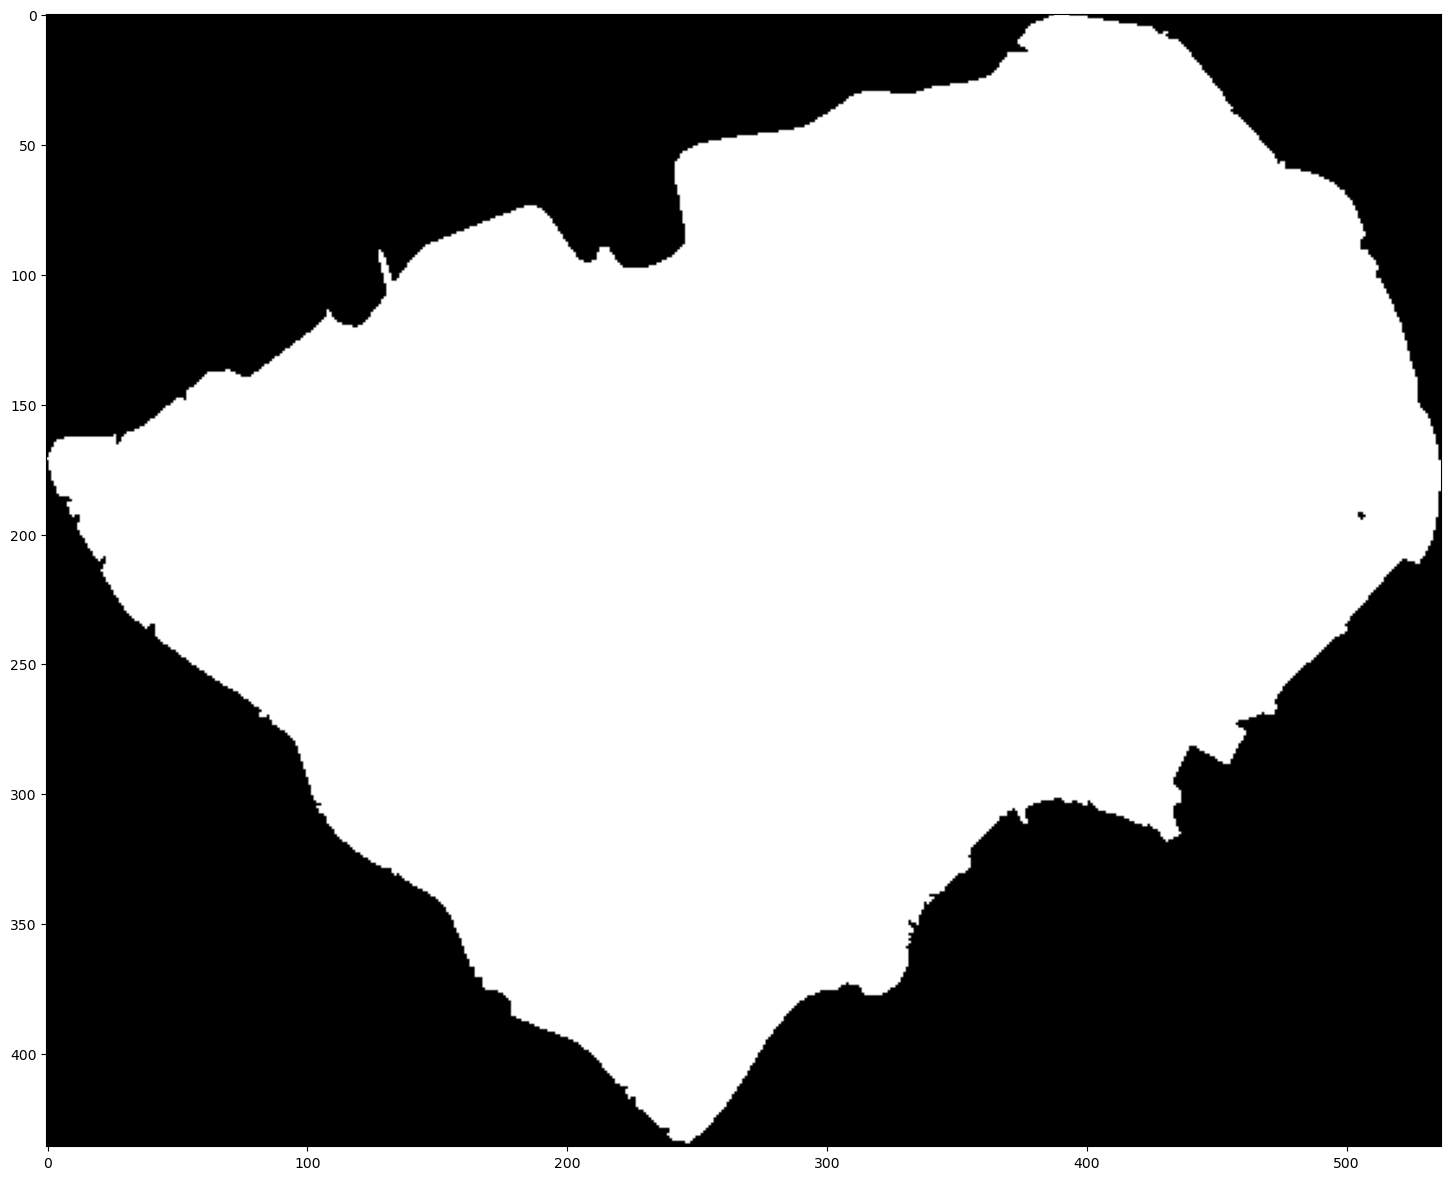

In [49]:
nReserve_proj = nReserve_geo.to_crs({'init': epsg})

with rio.open(str(object_name) +'.tiff') as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open('Masked_' +str(object_name) +'.tif', "w", **out_meta) as dest:
    dest.write(out_image)

msk = rio.open(r'Masked_' +str(object_name) +'.tif')
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show()

In [50]:
imgTif = 'Masked_' +str(object_name) +'.tif' # 読み出し用Tiffのパス
imgJpg = 'Masked_' +str(object_name) +'.jpg' # 書き出し用jpgのパスs


with rio.open(imgTif) as src:
  img_array = src.read() # 配列情報の読み取り

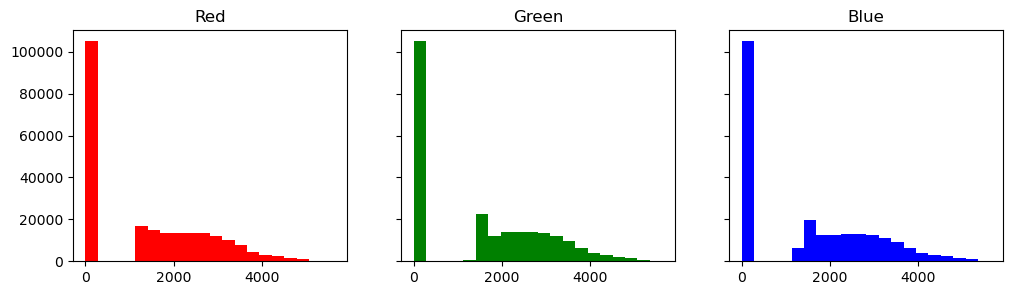

In [51]:
ep.hist(img_array,
        colors=['r', 'g', 'b'],
        title=['Red', 'Green', 'Blue'],
        cols=3,
        figsize=(12, 3));

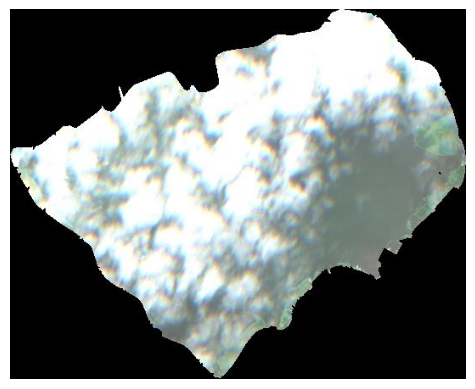

In [52]:
# gdal.Translate(imgJpg, imgTif, format='GTiff', scaleParams=[[0,3000,0,255]])
# # scaleParamsの部分は空白[[]]でも動作します。その場合は、gdal.Translateが自動で最適なコントラストに設定しますが、多くの場合手動でやるほうが良い結果になります
# im = Image.open('Masked_' +str(object_name) +'.jpg')
# im

# やや長いですが、下記方法でも変換可能です（より厳密な定義）
scale = '-scale 0 3000 0 255' # 画像の色調整を行います(16bitから8bit範囲へ変換)
options_list = [
    '-ot Byte', # 8bitまで扱う
    '-of JPEG', # 変換後の画像フォーマット
    scale # 画像のコントラスト
] 
options_string = " ".join(options_list)

gdal.Translate(imgJpg, # 変換後の画像（パスごと記入）
               imgTif, # 変換元の画像
               options=options_string) # オプション指定

# 画像を開く
image_path = imgJpg
img = Image.open(image_path)

# 画像を表示
plt.imshow(img)
plt.axis('off')  # 座標軸を非表示にする
plt.show()
     

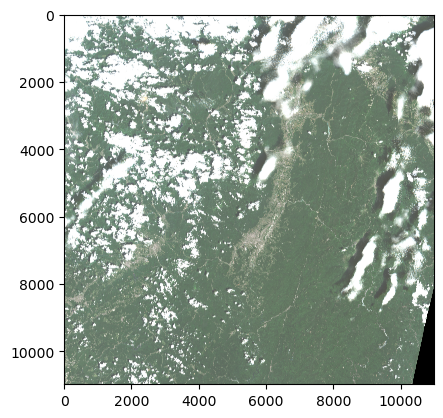

<Axes: >

In [53]:
# rio.openされたjp2ファイルを配列化
b, g, r = b2.read(1), b3.read(1), b4.read(1)
imgArray = np.array([r, g, b])

# RGB画像の最大値を調整（見た目を良くする作業）
imgArray[imgArray > 3000] = 3000
img = ((imgArray / imgArray.max()) * 255).astype(np.uint8)
rio.plot.show(img)
     


ここから先はtiffの表示及び，ピクセル値のgpd入力とポリゴンでの切り出し

#### 各代表エリア（geojson）形式のものをgeoDataFrameに読み込み，CRSを任意に変換した後に，shapelyのPolygonにする

In [96]:
OW_C = gpd.read_file("../raw_data/shapefile/OW_C.geojson", crs = "epsg:32654")

# 座標系をUTM Zone 54Nに変換します

OW_C

,geometry
0,"POLYGON ((237248.886 3992440.638, 237607.477 3..."


In [55]:
def geojson_to_gdf(geojson):    
    coords = list(geojson.iloc[0]['geometry'].exterior.coords)

    # 座標を[[x, y], ...]の形式coordsはタプルのリストだが，これを後でpolygonにするためにリストのリスト形式に変換する
    geodataFrame = [[x, y] for x, y in coords]
    
    return geodataFrame

In [82]:
gdf_OW_C = geojson_to_gdf(OW_C)
df = pd.DataFrame(gdf_OW_C, columns=['Latitude', "Longitude"])

# GeoDataFrameの作成
gdf = gpd.GeoDataFrame(df)
gdf

,Latitude,Longitude
0,237248.885683,3.992441e+06
1,237607.476923,3.992515e+06
2,238062.830879,3.992930e+06
3,237948.992390,3.993323e+06
4,237527.789981,3.993716e+06
5,236861.834820,3.993568e+06
6,236446.324335,3.993192e+06
7,236491.859731,3.992634e+06
8,237248.885683,3.992441e+06


In [97]:
# Transformerの挙動確認用
from pyproj import Transformer
epsg32653_to_epsg32654 = Transformer.from_crs("epsg:32654", "epsg:32654")

gdf_OW_C_after_trans = epsg32653_to_epsg32654.transform(gdf["Latitude"], gdf["Longitude"])

gdf_OW_C_after_trans

(array([237248.88568271, 237607.47692313, 238062.83087922, 237948.99239019,
        237527.78998081, 236861.83482003, 236446.3243351 , 236491.85973071,
        237248.88568271]),
 array([3992440.63799125, 3992514.63300911, 3992930.14349404,
        3993322.88628117, 3993715.6290683 , 3993567.63903257,
        3993191.97201879, 3992634.16342258, 3992440.63799125]))

In [94]:
# 変換器の初期化 (例として epsg:32653 から epsg:32654 に変換すると仮定します)
transformer = Transformer.from_crs("epsg:32654", "epsg:32654", always_xy=True)

# GeoDataFrame 内の座標を変換 (ここで gdf は元の GeoDataFrame)
# Latitude と Longitude の列から変換された座標のリストを作成
transformed_coords = [transformer.transform(x, y) for x, y in zip(gdf["Latitude"], gdf["Longitude"])]

# 変換された座標を使って Polygon オブジェクトを作成
polygon = Polygon(transformed_coords)

# 新しい GeoDataFrame を作成し、変換されたポリゴンを追加
gdf_transformed = gpd.GeoDataFrame(geometry=[polygon])

gdf_transformed

,geometry
0,"POLYGON ((237248.886 3992440.638, 237607.477 3..."


#### 既存のTiffファイル（10mのものと20mのもの）を読み込み，湖岸線と各外表エリアを可視化

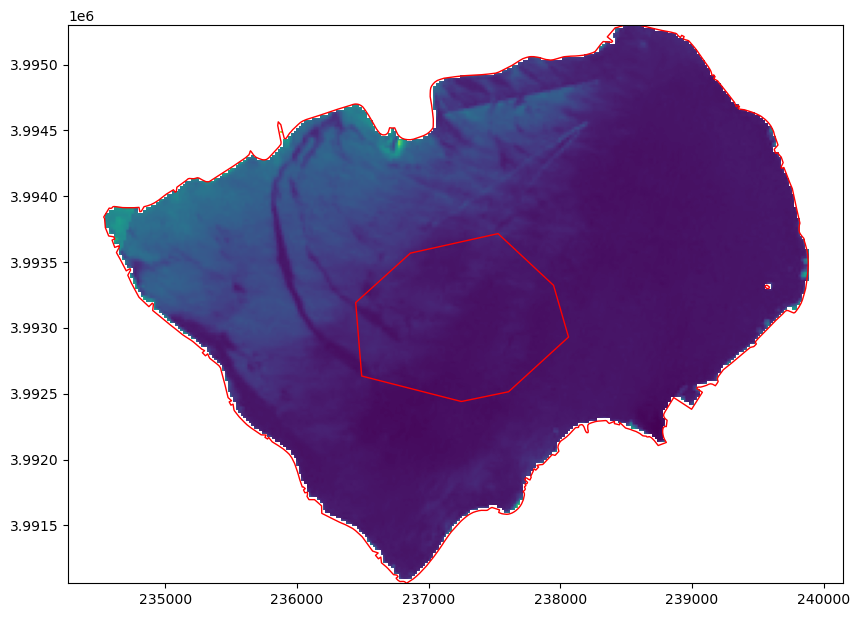

読み込みtiffのcrs：EPSG:32654


In [59]:
# TIFFファイル表示
open_tifffile_path = "../raw_data/2022_05_10_20m_suwako.tif"
# open_tifffile_path = "Masked_Suwako.tif"

# GeoTIFFファイルを読み込みます
with rasterio.open(open_tifffile_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    edge_line_utm = edge_line.to_crs(src.crs)
    # OW_C_utm = OW_C.to_crs(src.crs)
    # tiffファイルを表示
    show(src, ax=ax)
    # edge_line_utmを同じプロットに追加
    edge_line_utm.plot(ax=ax, edgecolor='red', facecolor='none')
    gdf_transformed.plot(ax=ax, edgecolor='red', facecolor='none')
    plt.show()
    print(f"読み込みtiffのcrs：{src.crs}")

In [70]:
# GeoJSONファイルを読み込みます
edge_line = gpd.read_file("../raw_data/shapefile/suwako_line.geojson", encoding="shift-jis")

# 湖岸線のgeodataframeの座標系を読み込んだtiffファイルのcrsに合わせる
edge_line_utm = edge_line.to_crs(src.crs)

# 最初のgeometryの座標を取得する（この例では最初のgeometryのみを取り扱っています）
coords = list(edge_line_utm.iloc[0]['geometry'].exterior.coords)

# 座標を[[x, y], ...]の形式coordsはタプルのリストだが，これを後でpolygonにするためにリストのリスト形式に変換する
output_coords = [[x, y] for x, y in coords]

# 変換後のgeometry属性を確認します
print(f"変換まえのcrs:{edge_line['geometry']}")
print(f"変換後のcrs：{edge_line_utm['geometry']}")


変換まえのcrs:0    POLYGON ((138.08298 36.06336, 138.08224 36.063...
Name: geometry, dtype: geometry
変換後のcrs：0    POLYGON ((237270.828 3994915.044, 237204.739 3...
Name: geometry, dtype: geometry


In [98]:
polygon_owc = geojson_to_gdf(OW_C)

#### 入力したtiffを入力したポリゴンで切り取る関数

In [74]:
def tiff_cut(open_tifffile_path, polygon):

    with rasterio.open(open_tifffile_path) as src:
        transform = src.transform
        
        # バンドのメタデータの取得
        band_descriptions = [src.descriptions[i-1] for i in range(1, src.count + 1)]
        
        # 各バンドを読み込む
        bands_data = []
        for i in range(1, src.count + 1):
            bands_data.append(src.read(i))

    # バンドの形状から座標を取得
    height, width = bands_data[0].shape
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    x_coords = (xs * transform[0]) + transform[2]
    y_coords = (ys * transform[4]) + transform[5]

    # GeoDataFrameの作成
    geometry = [Point(xy) for xy in zip(x_coords.flatten(), y_coords.flatten())]
    df = {'geometry': geometry}

    # 各バンドの値をDataFrameの列として追加
    for i, (band_data, band_description) in enumerate(zip(bands_data, band_descriptions)):
        # バンドの説明が存在しない場合は、デフォルトの名前を使用
        col_name = band_description if band_description else f'band_{i+1}'
        df[col_name] = band_data.flatten()

    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=src.crs)
    polygon = Polygon(polygon)

    polygon_gdf = gpd.GeoDataFrame([polygon], columns=['geometry'], geometry='geometry', crs="EPSG:32654") 
    polygon_gdf = polygon_gdf.to_crs(gdf.crs)
    sub_gdf = gdf[gdf.within(polygon_gdf.iloc[0].geometry)]
    
    return sub_gdf


In [101]:
sub_gdf_owc = tiff_cut(open_tifffile_path, polygon_owc)

In [114]:
sub_gdf_owc

,geometry,"B5, central wavelength 705 nm","B6, central wavelength 740 nm","B7, central wavelength 783 nm","B8A, central wavelength 865 nm","B11, central wavelength 1610 nm","B12, central wavelength 2190 nm","AOT, Aerosol Optical Thickness map (at 550nm)","CLD, Raster mask values range from 0 for high confidence clear sky to 100 for high confidence cloudy","SCL, Scene Classification","SNW, Raster mask values range from 0 for high confidence NO snow/ice to 100 for high confidence snow/ice","WVP, Scene-average Water Vapour map"
21506,POINT (237460.000 3993700.000),1420,1138,1154,1143,1242,1229,214,0,10,0,390
21507,POINT (237480.000 3993700.000),1431,1170,1165,1150,1263,1250,214,0,10,0,390
21508,POINT (237500.000 3993700.000),1469,1201,1187,1165,1293,1266,214,0,10,0,390
21509,POINT (237520.000 3993700.000),1483,1194,1192,1181,1291,1270,214,0,10,0,390
21510,POINT (237540.000 3993700.000),1465,1193,1182,1168,1283,1259,214,0,10,0,390
...,...,...,...,...,...,...,...,...,...,...,...,...
38050,POINT (237260.000 3992460.000),1298,1055,1070,1061,1174,1169,214,0,10,0,390
38051,POINT (237280.000 3992460.000),1300,1055,1070,1064,1174,1170,214,0,10,0,390
38052,POINT (237300.000 3992460.000),1300,1055,1070,1061,1171,1173,214,0,10,0,390
38053,POINT (237320.000 3992460.000),1303,1056,1069,1060,1169,1165,214,0,10,0,390


#### 入力したgdfを可視化する関数

In [112]:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

def display_geodf_as_raster(gdf, pixel_size, cmap='gray'):
    # GeoDataFrameの範囲を計算
    bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = bounds
    width = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))

    # ラスター変換のためのトランスフォーム
    transform = from_origin(minx, maxy, pixel_size, pixel_size)

    # ラスター化
    rasterized = rasterize(
        [(shape, 1) for shape in gdf.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,  # ラスター外の値
        all_touched=True
    )

    # ラスターデータを表示
    plt.imshow(rasterized, cmap=cmap, extent=(minx, maxx, miny, maxy))
    plt.title("Rasterized GeoDataFrame")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# 例: 使用方法
# gdf = 任意のGeoDataFrame
# display_geodf_as_raster(gdf, pixel_size=0.001, cmap='gray')
